Sequence where y_i = 0 for i <= n and y_{n + 1} = xor(x_1, x_2, ... x_n)

In [57]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [58]:
class Model(nn.Module):
    def __init__(self, hidden_size, x_size, y_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.x_size = x_size
        self.y_size = y_size
        
        self.Waa = nn.Linear(hidden_size, hidden_size)
        self.Wax = nn.Linear(x_size, hidden_size)
        self.g1 = nn.Tanh()
        
        self.Wya = nn.Linear(hidden_size, y_size)
    
    def forward(self, x, a):
        new_a = self.g1(self.Waa(a) + self.Wax(x))
        return self.Wya(new_a), new_a

In [59]:
def geseq_len(upper_bound=10):
    n = 1 + np.random.randint(1 + upper_bound)
    x = torch.rand(n + 1).round()
    x[n] = -1
    xor = (x.sum().item() + 1) % 2
    y = torch.zeros(n + 1)
    y[n] = xor
    return x.view(-1, 1), y.view(-1, 1), n + 1

geseq_len(2)

(tensor([[ 0.],
         [ 0.],
         [ 0.],
         [-1.]]),
 tensor([[0.],
         [0.],
         [0.],
         [0.]]),
 4)

It is essential to train model starting with small lengths. One can try to train model with sequence with length only 5 (I didn't manage to do it).

  0%|          | 0/19999 [00:00<?, ?it/s]

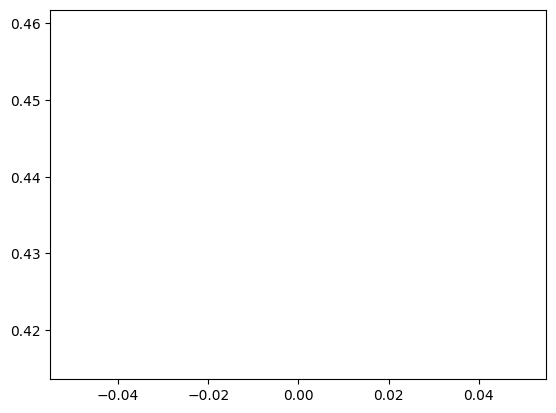

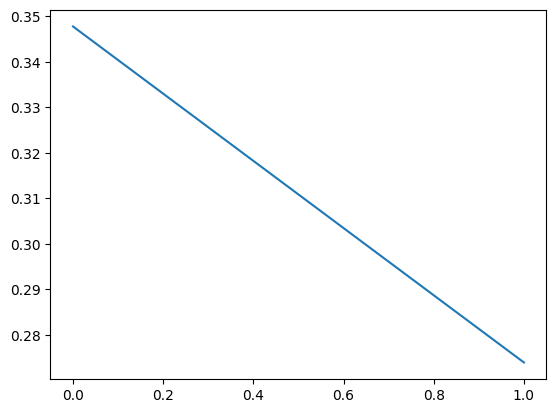

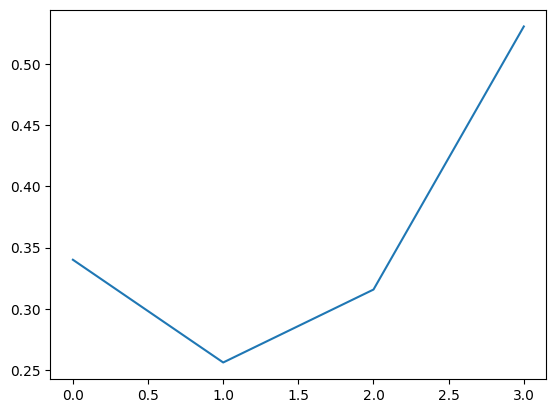

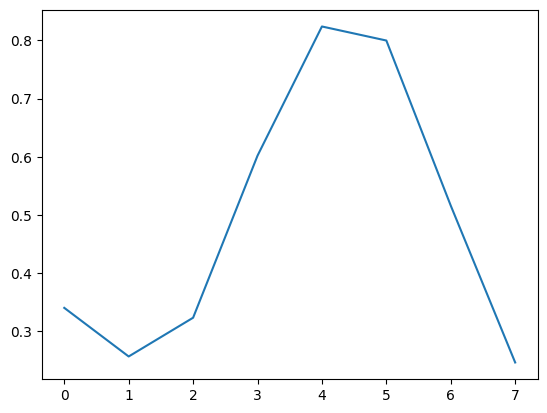

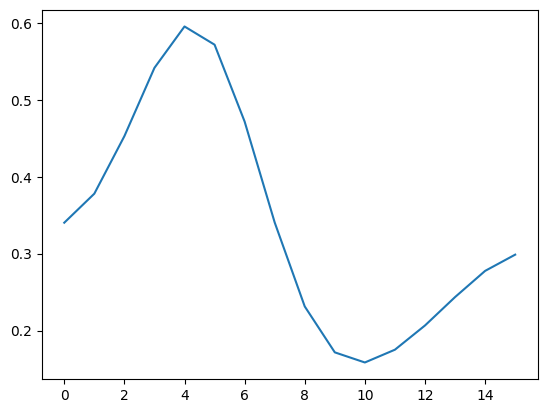

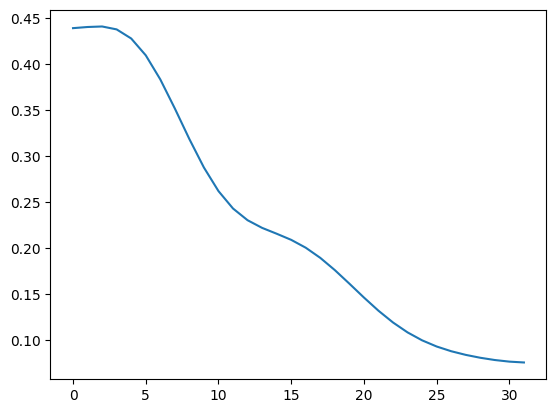

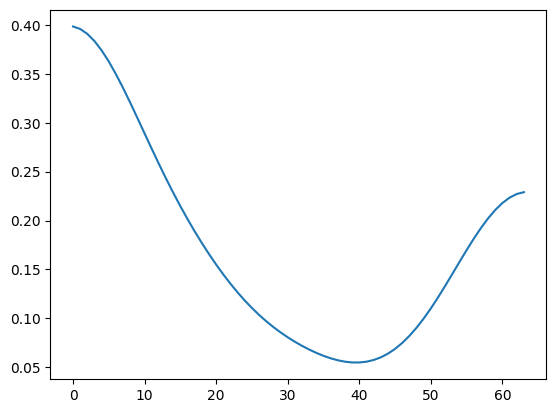

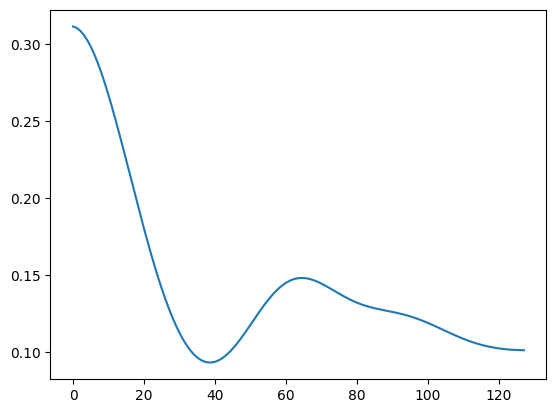

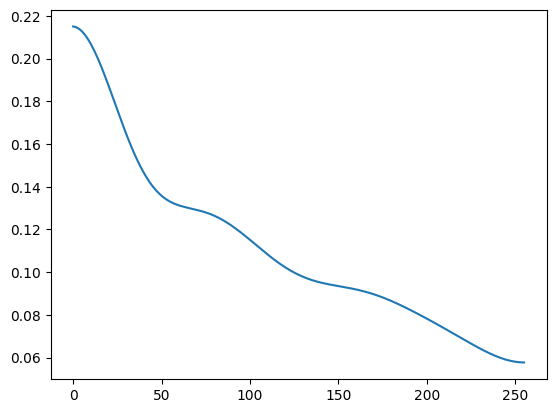

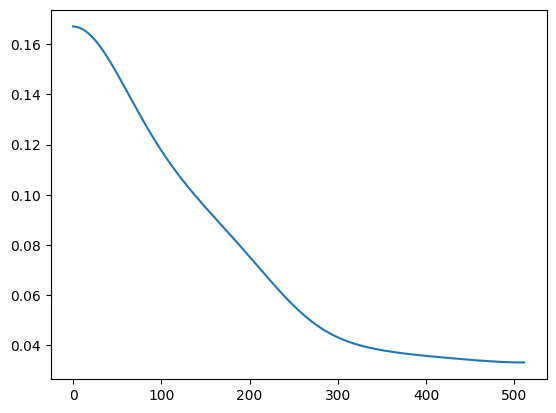

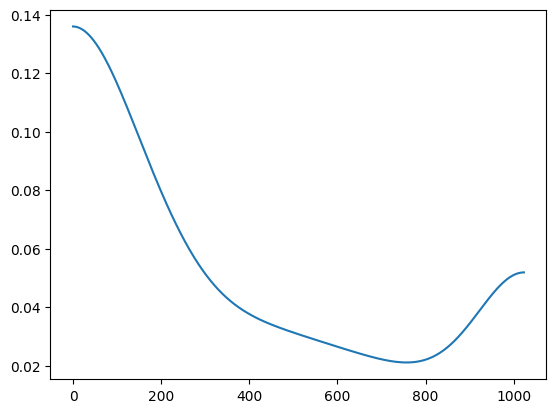

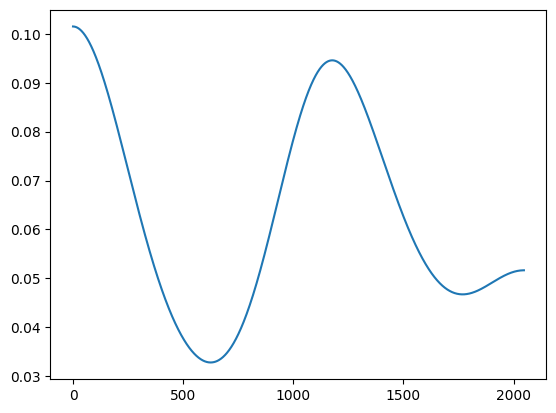

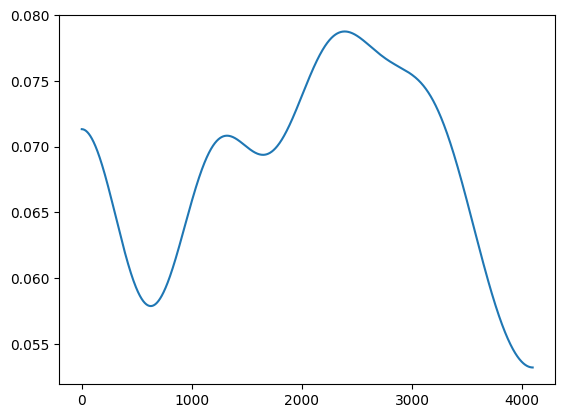

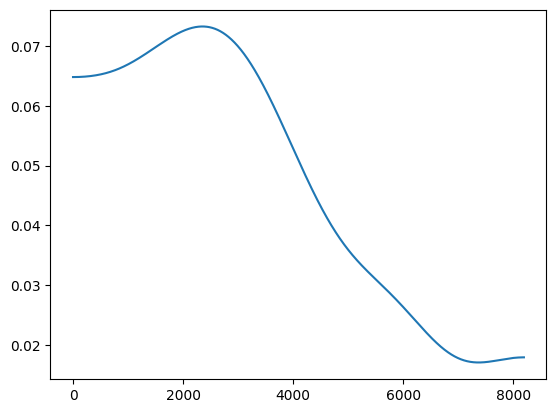

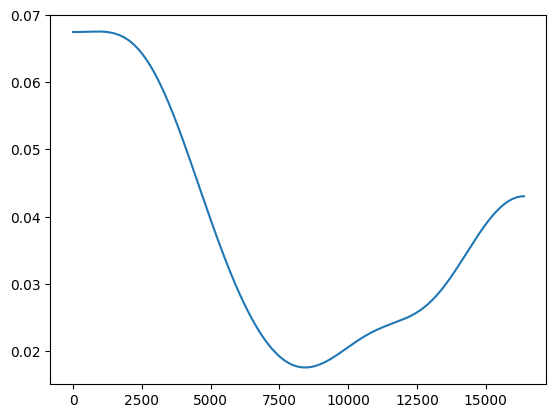

In [60]:
hsize = 100
net = Model(hsize, 1, 1)
optimizer = torch.optim.Adam(net.parameters())
losses = []
from scipy.ndimage import gaussian_filter1d

epochs = 20000
max_len = 20
for i in tqdm(range(1, epochs)):
    a = torch.randn(hsize)
    loss = 0
    
    # upper_bound goes from 0 to max_len - 1 while i increases
    x, y, n = geseq_len(i // (epochs // max_len))
    
    for it in range(n):
        y_pred, a = net(x[it], a)
        loss += F.mse_loss(y_pred, y[it])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if i & (i - 1) == 0:
        plt.plot(gaussian_filter1d(losses, i // 10 + 1))
        plt.show()

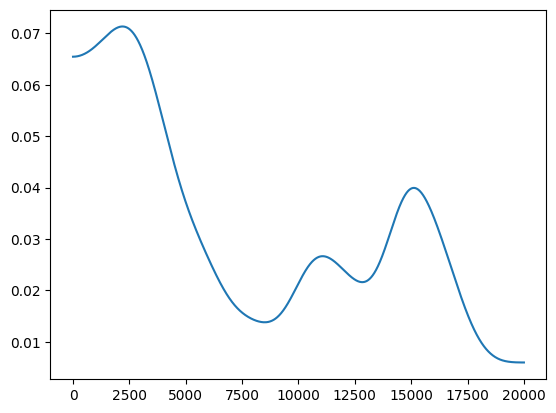

In [61]:
plt.plot(gaussian_filter1d(losses, 1000))
plt.show()

Model works with length 1000!

In [62]:
losses2 = []

epochs = 200
for i in tqdm(range(1, epochs)):
    a = torch.randn(hsize)
    loss = 0
    
    x, y, n = geseq_len(1000)
    
    for it in range(n):
        y_pred, a = net(x[it], a)
        loss += F.mse_loss(y_pred, y[it])
    

    losses2.append(loss.item())
sum(losses2) / len(losses2)

  0%|          | 0/199 [00:00<?, ?it/s]

0.05260863731440915

In [63]:
loss = 0

x, y, n = geseq_len(30)
print(x)
print(y)
print(n)

for it in range(n):
    y_pred, a = net(x[it], a)
    print(y_pred.item(), y[it].item())
    loss += F.mse_loss(y_pred, y[it])

print(loss.item())

tensor([[ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [-1.]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])
8
-0.04458409547805786 0.0
-0.008816733956336975 0.0
-0.018938913941383362 0.0
0.011762380599975586 0.0
-0.007964402437210083 0.0
-0.0032797902822494507 0.0
0.013593107461929321 0.0
0.9989814162254333 1.0
0.0028225108981132507
